In [1]:
import tensorflow as tf
print(tf.__version__)


2023-10-29 14:59:52.418817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2.12.0


In [2]:
#!pip install mlflow
#!pip install shap

## Importing Libraries

In [3]:
#ignore warnigns
import warnings
warnings.filterwarnings("ignore")
#library to code explanation
import shap

tf.random.set_seed(42) # For reproducibility
# Generate some random numbers
a = tf.random.uniform([1], seed=42)
b = tf.random.uniform([1], seed=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#metrics
from sklearn.model_selection import train_test_split




In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.Session(config=config)


In [6]:

# Including MLflow
import mlflow
import mlflow.tensorflow
import os
#print("MLflow Version: %s" % mlflow.__version__)

In [7]:
#keras
from keras import backend as K

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 0


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 47826628077907672
xla_global_id: -1
]


In [10]:
import pandas as pd
import numpy as np

In [11]:
#creating train_test data
target = pd.read_csv('path/scaled_target_var.csv')
features = pd.read_csv('path/scaled_features_var.csv', parse_dates=['Datetime'])

In [12]:
features.head()

,altitud,longitud,dirviento,nubosidad,temperatura,vapor,velviento,rocio,Datetime
0,-1.976249,1.016048,-0.824777,0.377910,-0.902988,-0.718679,0.331984,-0.707884,2016-01-01 07:00:00
1,-1.976249,1.016048,0.800002,0.223084,1.168718,0.270620,0.975889,0.657719,2016-01-01 13:00:00
2,-1.976249,1.016048,-1.569468,0.811498,-0.082978,0.450300,0.800677,0.349982,2016-01-01 19:00:00
3,-1.976249,1.016048,-2.923451,1.040877,-1.123230,-0.792431,0.126110,-0.734501,2016-01-02 07:00:00
4,-1.976249,1.016048,1.206197,0.167002,1.055059,-0.511945,0.770015,-0.479922,2016-01-02 13:00:00


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features[['altitud', 'longitud', 'dirviento', 'nubosidad', 'temperatura', 'vapor', 'rocio']], target, test_size=0.3)

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   altitud      815 non-null    float64       
 1   longitud     815 non-null    float64       
 2   dirviento    815 non-null    float64       
 3   nubosidad    815 non-null    float64       
 4   temperatura  815 non-null    float64       
 5   vapor        815 non-null    float64       
 6   velviento    815 non-null    float64       
 7   rocio        815 non-null    float64       
 8   Datetime     815 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(8)
memory usage: 57.4 KB


In [15]:
import matplotlib.pyplot as plt


In [16]:
def loos_visualization(history, num_model):
    # You can also visualize the training history to check for overfitting

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'path/modelo_{num_model}.png')
    plt.show()

In [17]:
tf_graph = tf.Graph()
tf_sess = tf.compat.v1.Session(graph=tf_graph)

In [18]:
import sys
sys.executable

'/opt/anaconda3/envs/tf/bin/python'

In [19]:
mlflow.tensorflow.autolog(every_n_iter=2)

In [20]:
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
from keras.layers import BatchNormalization

In [22]:
from keras.regularizers import l2


In [62]:
def runANN(activation, num_model, learning_rate, exp_name):

    model = Sequential()
    #add input layer
    model.add(Dense(units=80,
                    activation=activation,
                    input_dim = X_train.shape[1]))
    #add hidden layers
    model.add(BatchNormalization())
    model.add(Dense(units=228, activation=activation, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=128, activation=activation, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
 
    model.add(Dense(units=128, activation=activation, kernel_regularizer=l2(0.1)))
    #add output layer
    model.add(Dense(units=1, activation='linear'))

    #compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    mlflow.set_experiment(exp_name)

    with mlflow.start_run():

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping] )
        #evaluate the model on the test set
        y_pred = model.predict(X_test)

        # evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE): {mse}")
        rmse = np.sqrt(mse)
        print(f"Root Squared Error (RMSE): {rmse}")
        mae = mean_absolute_error(y_test, y_pred)
        print(f"Mean Absolute Error (MAE): {mae}")
        r2 = r2_score(y_test, y_pred)
        print(f"R squared (R2): {r2}")
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print(f"Mean Absolute Percentage Error (MAPE): {mape}")
        #visualization 
        loos_visualization(history, num_model)
        image_path = f'/Users/gloriacarrascal/trabajo-grado/graficas/modelo_{num_model}.png'
        #mlflow outputs
        mlflow.log_param("activation function", activation)
        mlflow.log_metric("Mean Squared Error_MSE", mse)
        mlflow.log_metric("Root Squared Error_RMSE", rmse)
        mlflow.log_metric("Mean Absolute Error_MAE", mae)
        mlflow.log_metric("R squared_R2", r2)
        mlflow.log_metric("Mean Absolute Percentage Error_MAPE", mape)
        mlflow.log_artifact(image_path)
        os.remove(image_path)
        #mlflow.tensorflow.log_model(model, "model")
        #mlflow.tensorflow.log_model(model, "model")
        mlflow.end_run()
    return y_pred



2023/10/30 22:29:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/100
 1/15 [=>............................] - ETA: 13s - loss: 33.6286WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_train_batch_end` time: 0.0045s). Check your callbacks.


15/15 [==============================] - 1s 11ms/step - loss: 30.1666 - val_loss: 27.5761
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 25.5066 - val_loss: 23.6856
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 21.7052 - val_loss: 20.1533
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 18.2741 - val_loss: 17.0551
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 15.3486 - val_loss: 14.3786
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 12.8413 - val_loss: 12.1370
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 10.7134 - val_loss: 10.2570
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 8.9764 - val_loss: 8.6908
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 7.5134 - val_loss: 7.3571
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 6.2669 - val_loss: 6.2739
Epoch 

2023/10/30 22:29:38 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/30 22:29:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023-10-30 22:29:38.946957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder te

INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmpo6lqx8hr/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmpo6lqx8hr/model/data/model/assets


8/8 [==============================] - 0s 904us/step
Mean Squared Error (MSE): 0.03651760781546042
Root Squared Error (RMSE): 0.19109580794842262
Mean Absolute Error (MAE): 0.13507261420422373
R squared (R2): 0.9649077615976818
Mean Absolute Percentage Error (MAPE): 0.27272928813280917


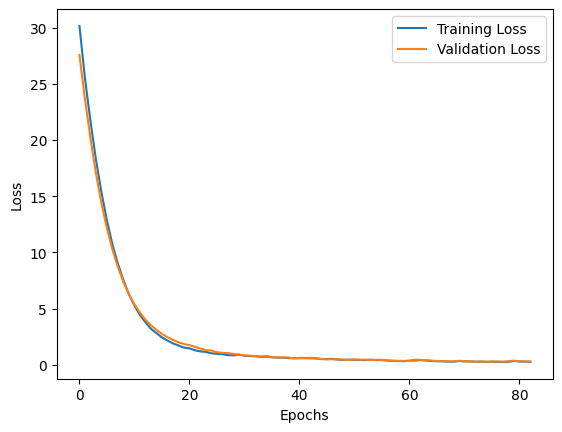

In [58]:
y_pred2 = runANN(activation='relu', num_model=3, learning_rate=0.001, exp_name='ANN1_normalizing')

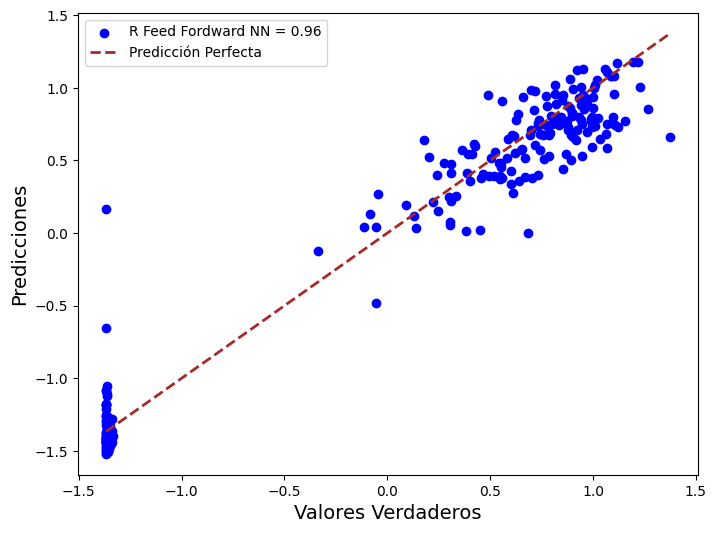

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred2)

# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', label=f'R Feed Fordward NN = {r_squared:.2f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, c='brown', label='Predicción Perfecta')
plt.xlabel('Valores Verdaderos', fontsize=14)
plt.ylabel('Predicciones', fontsize=14)
#plt.title(f'R = {r_squared:.2f}')
plt.legend()
plt.savefig(f'pathr_squared_FNN.png')
plt.show()


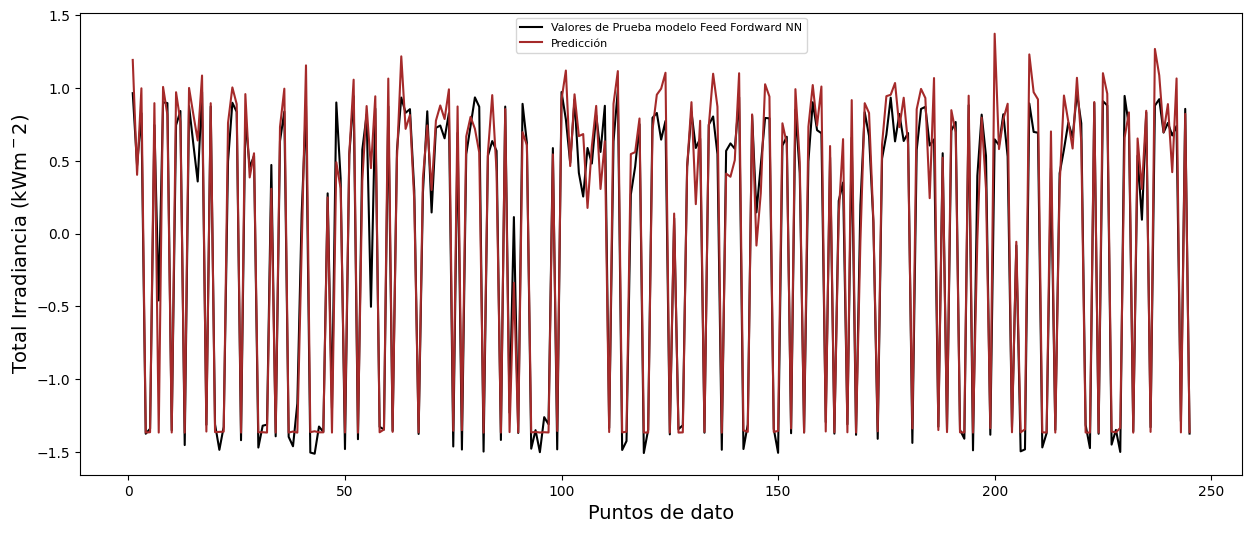

In [100]:

# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)

# Create a line chart for y_true and y_pred
plt.figure(figsize=(15,6), dpi=100)
plt.plot(x_axis, y_pred2, label='Valores de Prueba modelo Feed Fordward NN',linestyle='-', color='black')
plt.plot(x_axis, y_test, label='Predicción',linestyle='-', color='brown')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('Total Irradiancia (kWm$^-2$)', fontsize=14)
#plt.title('Valor vs. Predicted Values')
plt.legend(loc='upper center', fontsize=8)
plt.grid(False)
plt.savefig(f'path/timeserie_FNN.png')
plt.show()


In [79]:
len(y_test)

245

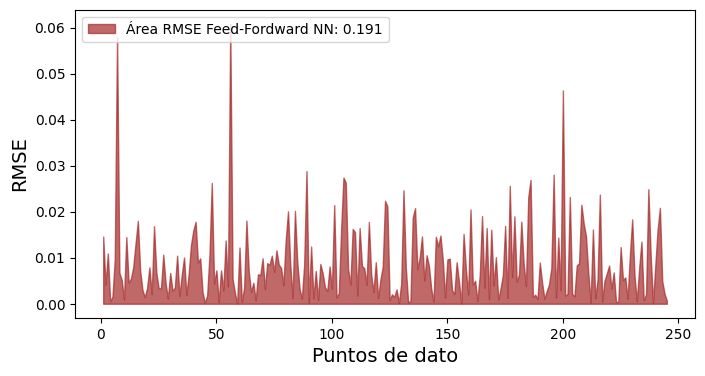

In [97]:

rmse = np.sqrt((y_test - y_pred2)**2 /len(y_test)) 


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
rmse = rmse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, rmse, alpha=0.7, color='brown', label='Área RMSE Feed-Fordward NN: 0.191')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'path/RMSE_FNN.png')
plt.show()


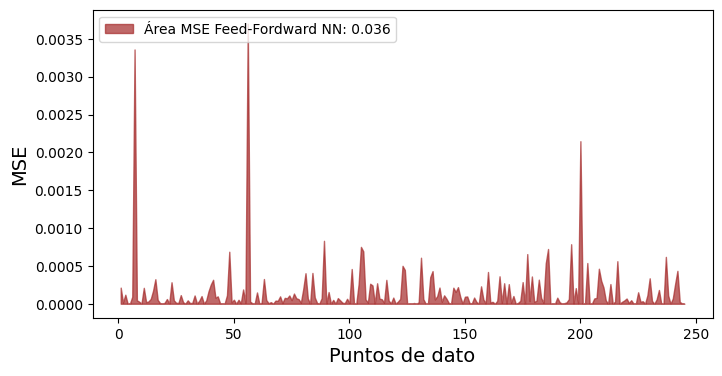

In [98]:

mse = (y_test - y_pred2)**2 /len(y_test)
# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mse = mse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mse, alpha=0.7, color='brown', label='Área MSE Feed-Fordward NN: 0.036')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'path/MSE_FNN.png')
plt.show()


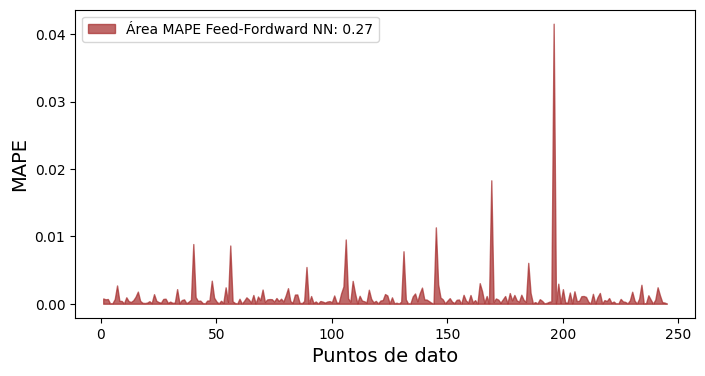

In [101]:

mape = np.abs((y_test - y_pred2)/y_test)/(len(y_test))
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mape = mape.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mape, alpha=0.7, color='brown', label='Área MAPE Feed-Fordward NN: 0.27')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAPE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'path/MAPE_FNN.png')
plt.show()

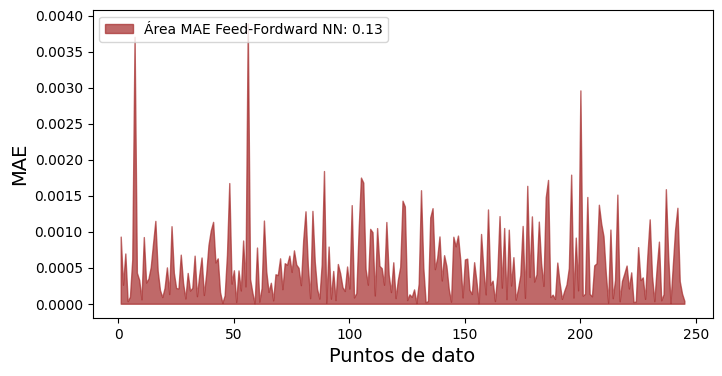

In [102]:
mae = np.abs(y_test - y_pred2)/len(y_test)


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mae = mae.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mae, alpha=0.7, color='brown', label='Área MAE Feed-Fordward NN: 0.13')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'path/MAE_FNN.png')
plt.show()